In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import urllib.request

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg.potential_fields import gravity
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

import numpy as np
import matplotlib.pyplot as plt
from discretize import TreeMesh
from discretize.utils import mkvc

# sphinx_gallery_thumbnail_number = 3

In [2]:

import matplotlib
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

# from SimPEG.potential_fields import magnetics
# from SimPEG import dask
# from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import pandas as pd
from ipywidgets import widgets, interact

C:\Users\gabri\AppData\Local\Temp\ipykernel_3152\3764283650.py:13: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import (


In [3]:
import os
import urllib.request
import tarfile

# Enlace de Google Drive (modificado para descarga directa)
data_source = "https://drive.google.com/uc?export=download&id=10aEQOnrprAyIFMWPicd8ZAznM1UDCol9"

# Descargar el archivo y guardar el nombre local
downloaded_data = "data.tar.gz"
print(f"Downloading data from: {data_source}")
urllib.request.urlretrieve(data_source, downloaded_data)
print(f"File downloaded: {downloaded_data}")

# Descomprimir el archivo .tar.gz
if tarfile.is_tarfile(downloaded_data):
    with tarfile.open(downloaded_data, "r:gz") as tar:
        # Extraer los archivos al directorio actual
        tar.extractall()
    print("Files extracted.")
else:
    print("The downloaded file is not a tar.gz file.")

# Definir el directorio que contiene los datos descomprimidos
dir_path = os.path.join("Inv_Gravity_Anomaly_3D_VCM", "")  # Ruta a la carpeta descomprimida

# Nombres de los archivos con rutas completas
topo_filename = os.path.join(dir_path, "gravity_topo_480.txt")
data_filename = os.path.join(dir_path, "Puntos_480_dato_real.txt")

# Verificación de los archivos
if os.path.exists(topo_filename):
    print(f"Topo file located: {topo_filename}")
else:
    print(f"Topo file not found: {topo_filename}")

if os.path.exists(data_filename):
    print(f"Data file located: {data_filename}")
else:
    print(f"Data file not found: {data_filename}")

File downloaded: data.tar.gz
Files extracted.
Topo file located: Inv_Gravity_Anomaly_3D_VCM\gravity_topo_480.txt
Data file located: Inv_Gravity_Anomaly_3D_VCM\Puntos_480_dato_real.txt


In [4]:
# Load topography
xyz_topo = np.loadtxt(str(topo_filename))
xyz_topo

array([[853650. , 987570. ,   2248.9],
       [853710. , 987570. ,   2298.2],
       [853780. , 987570. ,   2331.1],
       ...,
       [855400. , 988560. ,   2519.7],
       [855470. , 988560. ,   2530.4],
       [855530. , 988560. ,   2558.3]])

In [5]:
# Load field data
dobs = np.loadtxt(str(data_filename))
dobs

array([[ 8.53646789e+05,  9.87574589e+05,  2.24885708e+03,
        -4.01059100e+00],
       [ 8.53711789e+05,  9.87574589e+05,  2.29820224e+03,
        -4.14598130e+00],
       [ 8.53776789e+05,  9.87574589e+05,  2.33112432e+03,
        -4.47058530e+00],
       ...,
       [ 8.55401789e+05,  9.88564589e+05,  2.51974978e+03,
        -3.40438700e+00],
       [ 8.55466789e+05,  9.88564589e+05,  2.53040825e+03,
        -2.85889390e+00],
       [ 8.55531789e+05,  9.88564589e+05,  2.55830808e+03,
        -2.39132830e+00]])

In [6]:
# Definir las ubicaciones de los receptores y los datos observados
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

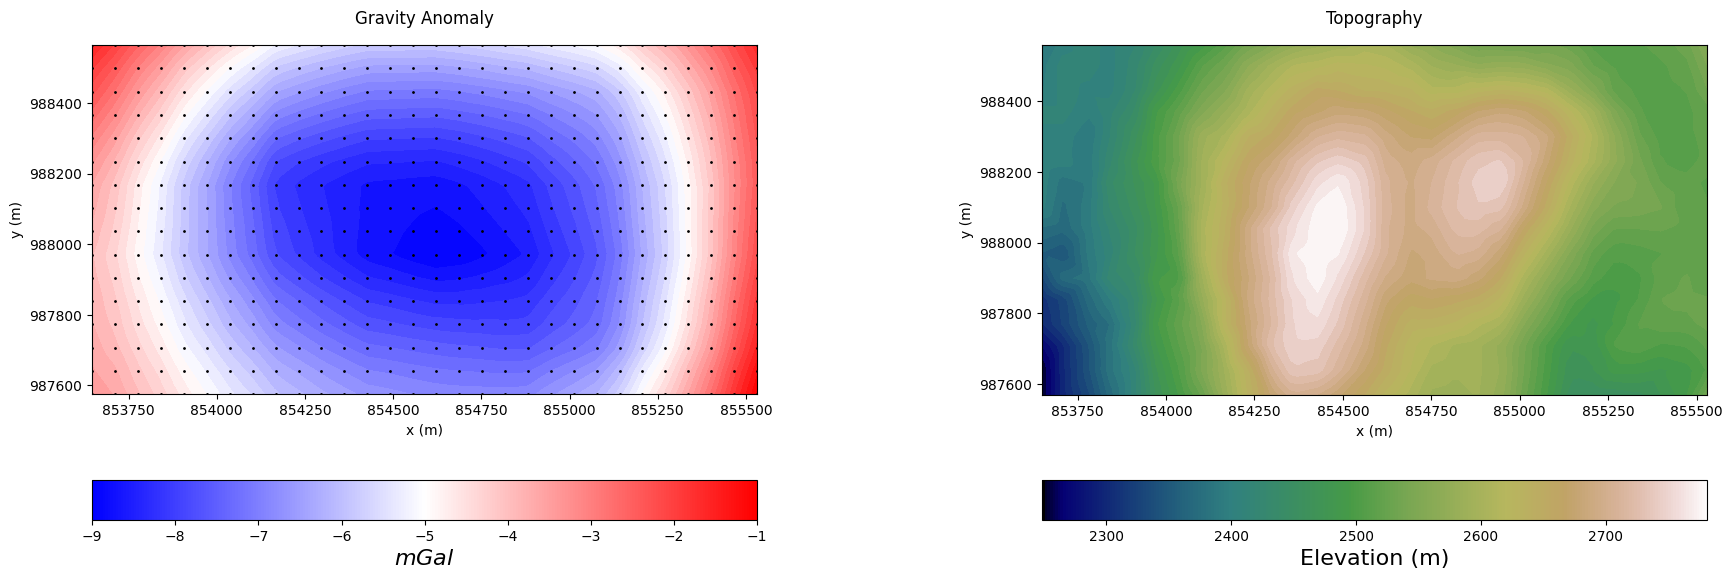

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# Normalización de los datos de 'dobs' para el rango de -16 a 8
norm = mpl.colors.Normalize(vmin=-9, vmax=-1)
dobs_normalized = norm(dobs)  # Normalización de los datos
# dobs=dobs_normalized

# Crear la figura
fig = plt.figure(figsize=(19, 10))

# Primer gráfico: Anomalía de gravedad
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

# Usar el método plot2Ddata() para plotear los datos
# Asumiendo que plot2Ddata es una función definida previamente
# Asegúrate de que esta función reciba correctamente los datos normalizados.
plot2Ddata(
    receiver_locations,
    dobs_normalized,  # Usamos los datos normalizados
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)

ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

# Barra de color para la primera figura
cx1 = fig.add_axes([0.05, 0.35, 0.35, 0.04])
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)

# Segundo gráfico: Topografía
ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    xyz_topo[:, 0:2],  # Coordenadas X, Y de la topografía
    xyz_topo[:, -1],    # Altura de la topografía (Z)
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)

ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

# Barra de color para la segunda figura
cx2 = fig.add_axes([0.55, 0.35, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(xyz_topo[:, -1]), vmax=np.max(xyz_topo[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("Elevation (m)", size=16)

# Mostrar el gráfico
plt.show()


In [8]:
#Definir desviación estandar de nuestros datos, en este caso, será de 1
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.01 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.09062774700000001


In [9]:
# Definir los receptores (con los puntos XYZ). Los datos consisten en mediciones de anomalías verticales de gravedad. 
# El conjunto de receptores debe definirse como una lista.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Definir el campo de la fuente
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define el survey (sondeo)
survey = gravity.survey.Survey(source_field)

In [10]:
#Definir los datos que serán invertidos
data_object = data.Data(survey, dobs=-dobs, standard_deviation=uncertainties)

<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

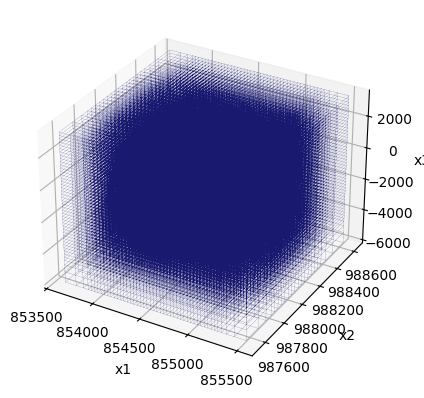

In [11]:
#definir la malla
dx = 35
ncx = 40
dy = 37
ncy = 15
dz = 200
ncz = 40
dpadh = 3.5
exp_h = 1.5

hx = [(dx, dpadh, -exp_h), (dx, ncx), (dx, dpadh, exp_h)]
hy = [(dy, dpadh, -exp_h), (dy, ncy), (dy, dpadh, exp_h)]
hz = [(dz, 3, -exp_h), (dz, ncz)]
mesh = TensorMesh([hx, hy, hz], x0=[853614,987543,-6000])

                           
mesh.plot_grid(color="midnightblue", linewidth=0.1)

In [12]:
#Modelo inicial/de referencia y mapeo en la malla tensorial
#Creamos el modelo de partida para la inversión desde el espacio del modelo a las celdas vacías
#Los modelos de partida y de referencia pueden ser un valor de fondo constante

# Encuentra los índices de las celdas activas en el modelo de avance (las que están por debajo de la superficie)
active_tensor_cells = active_from_xyz(mesh, xyz_topo)

# Definir la asignación del modelo a las celdas activas
n_tensor_active = int(active_tensor_cells.sum())

#Mapping from the Model to Active Cells
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)  #El modelo consiste en un valor para cada celda activa


In [13]:
# Definir y trazar el modelo inicial
starting_tensor_model = -0.1 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [14]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(mesh, active_tensor_cells, np.nan)

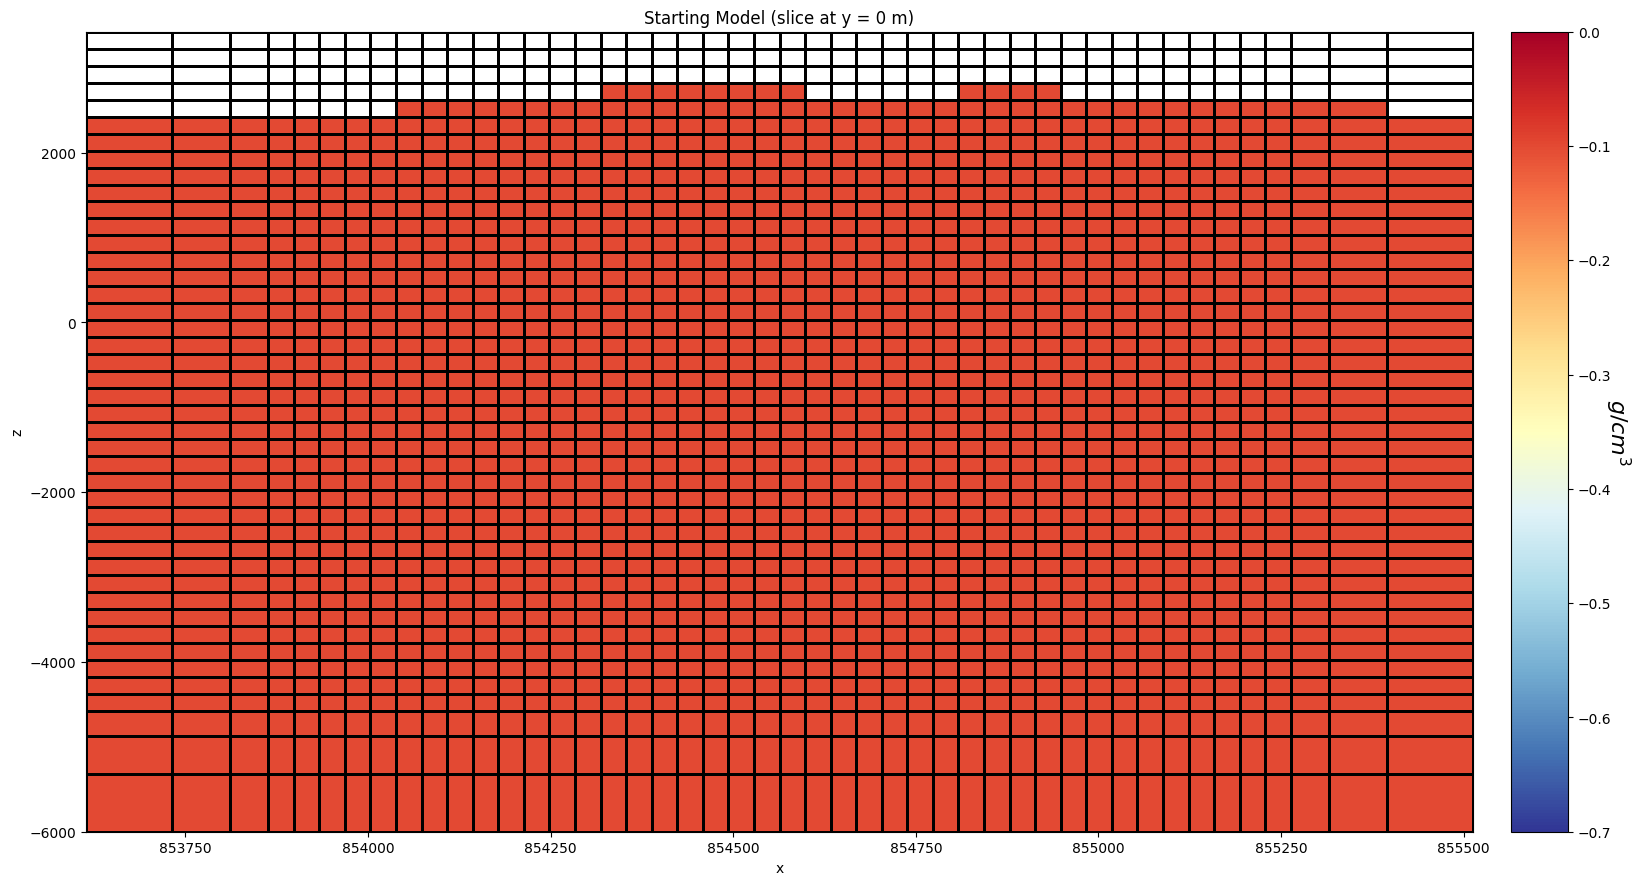

In [15]:
fig = plt.figure(figsize=(19, 10))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)
mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [16]:
#Definimos la física del problema de la gravedad utilizando la clase de simulación.
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="choclo",
)

In [17]:
#Definición del problema inverso

# Definir el desajuste de datos. Aquí el desajuste de datos es la norma L2 del residuo 
# ponderado entre los datos observados y los datos predichos para un modelo dado.
# Dentro del desajuste de datos, el residuo entre los datos predichos y observados son
# normalizados por la desviación estándar de los datos.
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)
dmis_L2.W = utils.sdiag(1 / uncertainties)



# Definir la regularización (función objetivo del modelo).

reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_tensor_cells,
    mapping=tensor_model_map,
    length_scale_x=10.0,
    length_scale_y=10.0,
    length_scale_z=10.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=True,
)

# reg_L2 = regularization.WeightedLeastSquares(
#     mesh, 
#     active_cells=active_tensor_cells,
#     mapping=tensor_model_map,
#     alpha_s=1e-5, 
#     alpha_x=1/5, 
#     alpha_y=1/5, 
#     alpha_z=1/3, 
#     alpha_xx=1/5, 
#     alpha_yy=1/5, 
#     alpha_zz=1/3,
#     reference_model=reference_tensor_model, 
#     reference_model_in_smooth=True, 

# )



In [18]:
# Definir cómo se resuelve el problema de optimización. Aquí vamos a utilizar un enfoque
# Gauss-Newton proyectado que emplea el solucionador de gradiente conjugado.
opt_L2 = optimization.InexactGaussNewton(
           maxIter=150, maxIterLS=30, maxIterCG=70, tolCG=1e-3
)

In [19]:
# Aquí definimos el problema inverso que hay que resolver
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [20]:
# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration()
save_iteration.outDict = {}

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=True, 
                                                          threshold_value=1e-5, 
                                                          threshold_method='amplitude', 
                                                          normalization_method='maximum')
                                                         # )
# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
# Definir un valor inicial para el parámetro de compensación (beta) entre el 
# desajuste de los datos y la regularización.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=20)
# Taza de diminución del valor de Beta
beta_schedule = directives.BetaSchedule(coolingFactor=3.0, coolingRate=1) 

target_misfit = directives.TargetMisfit(chifact=0.3)



# The directives are defined as a list.
directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_iteration,
]



In [21]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.64e-04  1.06e+06  3.02e+06  1.06e+06    1.28e+05      0              


C:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\simpeg\optimization.py:1072: UserWarning: tol is not a valid keyword for cg and will be ignored
  Hinv = SolverICG(


   1  2.21e-04  7.51e+03  3.10e+07  1.44e+04    2.30e+03      0              
   2  7.38e-05  3.86e+03  4.05e+07  6.85e+03    1.26e+03      0   Skip BFGS  
   3  2.46e-05  1.88e+03  5.58e+07  3.26e+03    6.25e+02      0   Skip BFGS  
   4  8.19e-06  9.14e+02  7.82e+07  1.55e+03    3.01e+02      0   Skip BFGS  
   5  2.73e-06  4.47e+02  1.11e+08  7.49e+02    1.46e+02      0   Skip BFGS  
   6  9.11e-07  2.26e+02  1.56e+08  3.69e+02    6.92e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.0621e+05
0 : |xc-x_last| = 7.1102e+00 <= tolX*(1+|x0|) = 2.0375e+00
0 : |proj(x-g)-x|    = 6.9202e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.9202e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     150    <= iter          =      7
------------------------- DONE! -------------------------


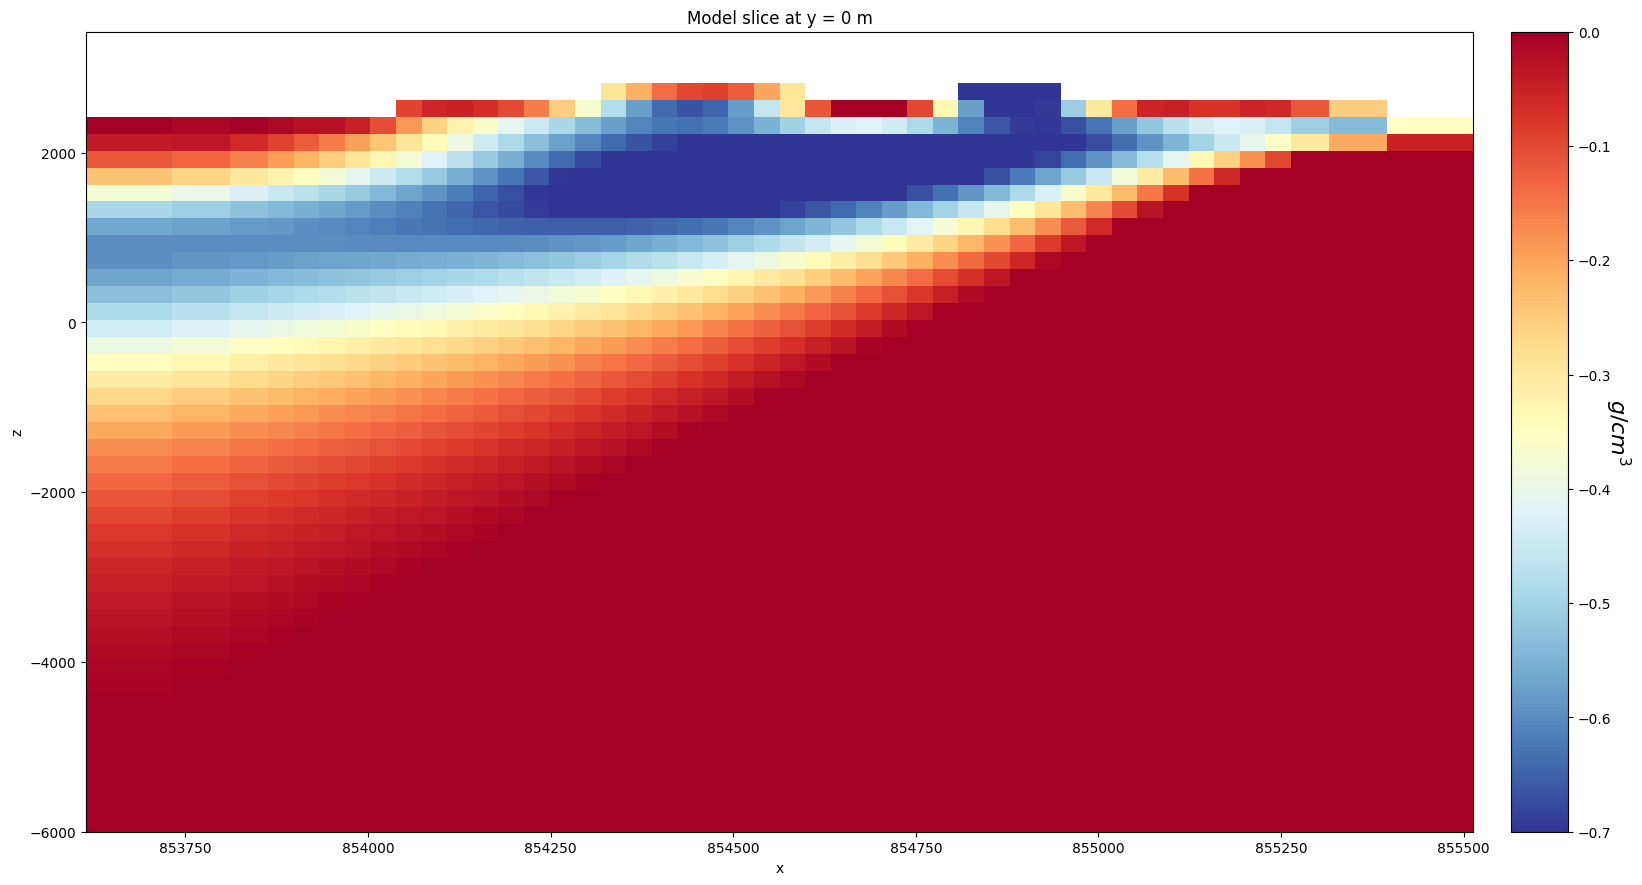

In [22]:
# Plot Recovered Model
fig = plt.figure(figsize=(19, 10))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

# norm = mpl.colors.Normalize(
#     vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
# )

norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)

mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()


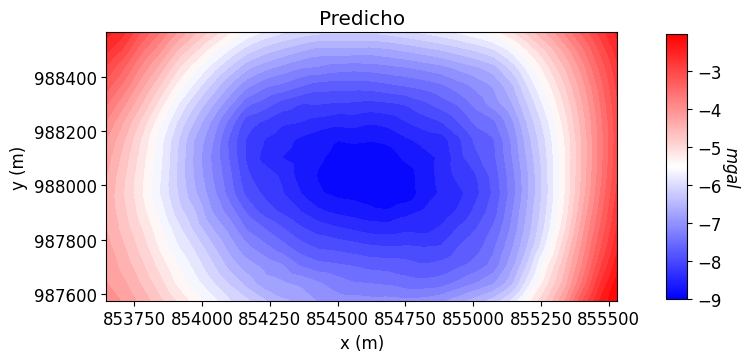

In [23]:
#Plotear el valor predicho
dpred = (-inv_prob_L2.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred), np.max(dpred), np.min(-dpred), np.max(-dpred)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred, 
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

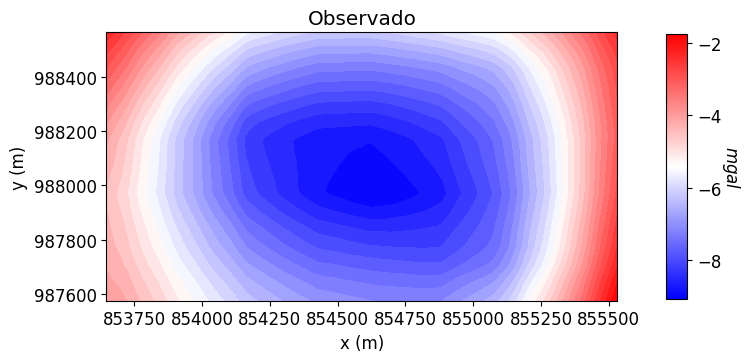

In [24]:
#Plotear el valor observado
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

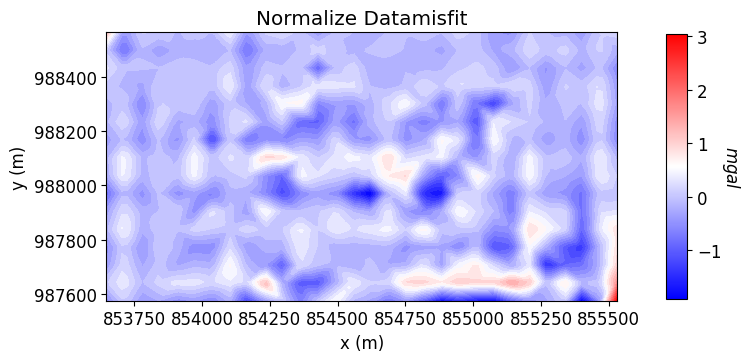

In [25]:
data_misfit= (dobs - dpred) / uncertainties


mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit), vmax=np.max(data_misfit))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [26]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration.outDict[kk]['phi_d'])
        phi_m.append(save_iteration.outDict[kk]['phi_m'])
        beta.append(save_iteration.outDict[kk]['beta'])
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(phi_m ,phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1] ,phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    axs[1].plot(iterations, phi_d, 'k.-')
    axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    ax_1 = axs[1].twinx()
    ax_1.plot(iterations, phi_m, 'r.-')
    ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    axs[0].legend()

    plt.tight_layout()    

In [27]:
target_misfit.target

144.0

In [28]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration.outDict[kk]['phi_d'])
        phi_m.append(save_iteration.outDict[kk]['phi_m'])
        beta.append(save_iteration.outDict[kk]['beta'])
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
    # Primera gráfica
    axs[0].plot(phi_m, phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)
    
    # Segunda gráfica
    line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
    point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    
    ax_1 = axs[1].twinx()
    line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
    point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    
    # Añadir leyendas
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    axs[1].legend(lines, labels, loc='upper left')
    
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    
    axs[0].legend()
    plt.tight_layout()    

interact(
    plot_tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), step=1),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, description='iteration', max=7, min=1), RadioButtons(description='sca…

<function __main__.plot_tikhonov_curve(iteration, scale)>

In [29]:
def plot_interactive_results(iteration):
    # Calcular data misfit normalizado
    dobs_iter = dobs
    
    # Obtener datos predichos de la iteración específica
    dpred_iter = save_iteration.outDict[iteration]['dpred']
    
    # Calcular data misfit normalizado
    data_misfit_iter = (dobs - dpred) / uncertainties
    
    # Configurar figura
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(19, 9))

    #Plotear el valor observado
    plot2Ddata(
        receiver_locations,
        dobs_iter,
        ax=ax0,
        ncontour=30,
        contourOpts={"cmap": "Spectral_r"}
    ) 
    ax0.set_title(f"Observado - Iteration {iteration}")
    ax0.set_xlabel("x (m)")
    ax0.set_ylabel("y (m)")  
    
    # Plotear datos predichos
    plot2Ddata(
        receiver_locations, 
        -dpred_iter, 
        ax=ax1, 
        ncontour=30, 
        contourOpts={"cmap": "Spectral_r"}
    )
    ax1.set_title(f"Predicted Data - Iteration {iteration}")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("y (m)")
    
    # Plotear data misfit normalizado
    plot2Ddata(
        receiver_locations, 
        data_misfit_iter, 
        ax=ax2, 
        ncontour=30, 
        contourOpts={"cmap": "Spectral_r"}
    )
    ax2.set_title(f"Normalized Data Misfit - Iteration {iteration}")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("y (m)")
    
    plt.tight_layout()
    plt.show()

# Crear widget interactivo
interact(plot_interactive_results, 
         iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), step=1)
)

interactive(children=(IntSlider(value=1, description='iteration', max=7, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_interactive_results(iteration)>

In [30]:
def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
    # Recuperar el modelo
    model = save_iteration.outDict[iteration]['m']

    # Expandir el modelo si el tamaño no coincide con el total de celdas
    if model.size != mesh.nC:
        expanded_model = np.zeros(mesh.nC)  # Crear un modelo vacío para todas las celdas
        expanded_model[:model.size] = model  # Asignar valores a las celdas disponibles
    else:
        expanded_model = model  # Usar el modelo directamente

    
    # Crear la figura
    fig = plt.figure(figsize=(12, 8))

    # Calcular los límites de los colores con base en los valores del modelo
    clim = [expanded_model.min(), expanded_model.max()]
    
    # Usar plot_3d_slicer y obtener los cortes en los tres planos
    mesh.plot_3d_slicer(
        expanded_model,
        clim=clim,
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap': 'Spectral_r'}
    )
    
    # Configurar barra de colores manualmente
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []  # Esto es necesario para matplotlib
    cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Density (g/cm³)', rotation=270, labelpad=20)

    # Configurar el título
    plt.suptitle(f'Recovered Model - Iteration {iteration}', fontsize=16)
    plt.show()

# Configurar widgets interactivos
interact(
    plot_recovered_model, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), value=0),
    xslice=widgets.FloatText(value=854500, step=1),
    yslice=widgets.FloatText(value=988000, step=1), 
    zslice=widgets.FloatText(value=2000, step=1),
    vmax=widgets.FloatText(value=0.7)
)




interactive(children=(IntSlider(value=1, description='iteration', max=7, min=1), FloatText(value=854500.0, des…

<function __main__.plot_recovered_model(iteration, xslice, yslice, zslice, vmax)>

In [31]:
import pyvista as pv

def plot_3d_with_pyvista(model, notebook=True, threshold=-0.9):
    pv.set_plot_theme("document")
    
    # Expandir el modelo si es necesario
    if model.size != mesh.nC:
        expanded_model = np.zeros(mesh.nC)  # Crear un modelo lleno de ceros para todas las celdas
        expanded_model[:model.size] = model  # Asignar valores a las celdas activas
    else:
        expanded_model = model  # Usar el modelo directamente

    # Convertir la malla a un dataset de PyVista
    dataset = mesh.to_vtk({'Densidad': expanded_model})
    
    # Crear la escena de renderizado
    p = pv.Plotter(notebook=notebook)
    p.hide_axes()  # Ocultar los ejes para una visualización más limpia
    # p.show_grid()  # Mostrar la cuadrícula
    
    # Filtrar por un umbral
    threshed = dataset.threshold(-threshold, invert=True)

    # Calcular los límites de los colores con base en los valores del modelo
    clim = [expanded_model.min(), expanded_model.max()]

    # Definir argumentos de la barra de colores
    scalar_bar_args = {
        'title': 'mGal',  # Título de la barra de colores
        'vertical': False
    }
    
    # Agregar los datos volumétricos a la escena
    dparams = dict(
        show_edges=False,
        cmap="Spectral_r",
        clim=clim,
        scalar_bar_args=scalar_bar_args,  # Argumentos de la barra de colores
    )
    p.add_mesh(threshed, **dparams)
    
    # Ajustar la escala y la posición de la cámara
    p.set_scale(1, 1, 0.1)
    
    # Mostrar la escena
    p.show(window_size=[1024, 768])

# Llamar a la función con el modelo expandido
plot_3d_with_pyvista(recovered_tensor_model, notebook=False, threshold=0.6)


In [32]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties


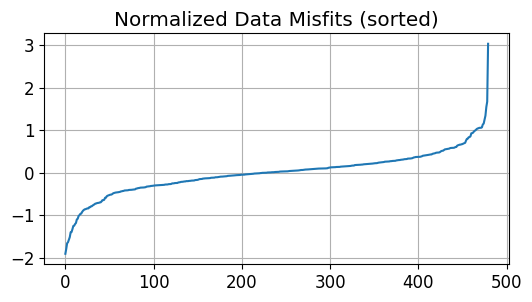

In [33]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)

In [34]:
# Generate new uncertainties
new_uncertainties = uncertainties.copy()
new_uncertainties[np.abs(normalized_data_misfits) > 2.0] /= 2.5

In [35]:
# Generate new data object
new_data_object = data.Data(survey, dobs=dobs, standard_deviation=new_uncertainties)


Text(0.5, 1.0, 'Cell Log-Volumes at Y = 0 m')

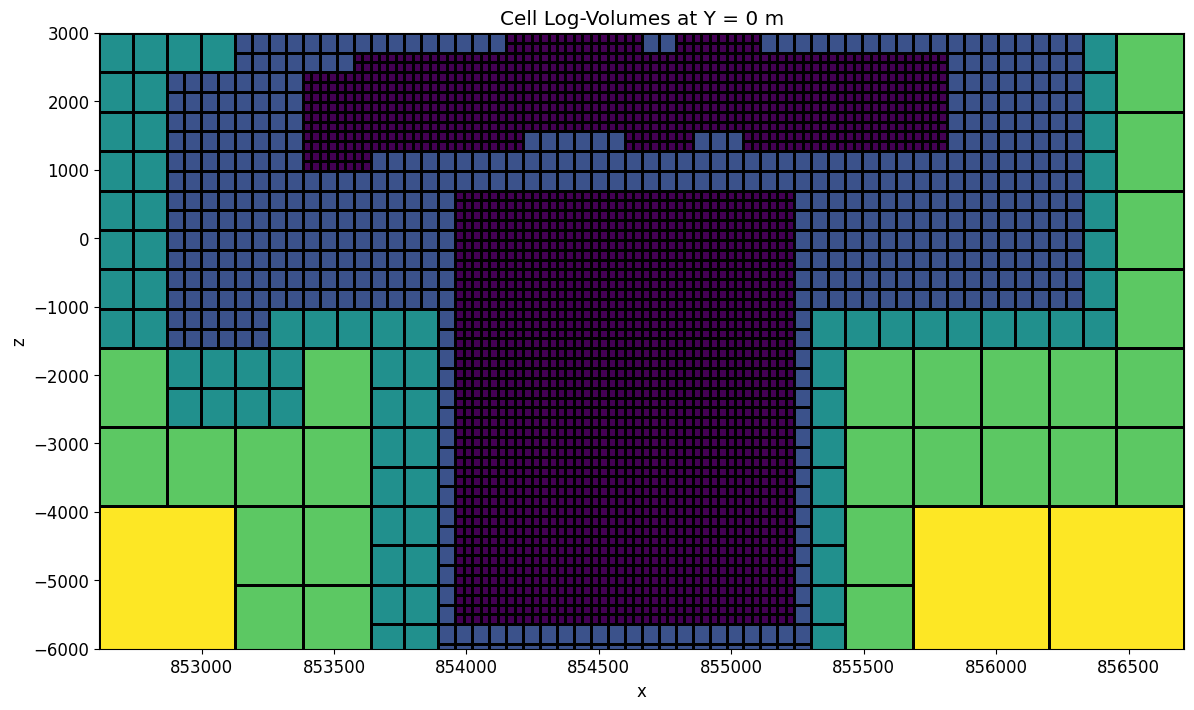

In [36]:
import numpy as np
from discretize import TreeMesh

# Aumenta ligeramente los tamaños de celda mínimos
dx = 32  # incrementado de 32 a 40
dy = 16  # incrementado de 64 a 80
dz = 144  # incrementado de 80 a 100

# Define domain dimensions
x_length = 2954.0
y_length = 1072.0
z_length = 7000.0

# Compute number of base mesh cells required in x, y, and z
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]

# Define starting coordinates
x0 = [852614, 987543, -9000]

# Create mesh
tree_mesh = TreeMesh([hx, hy, hz], x0=x0)

# Shift vertically to top same as maximum topography
tree_mesh.origin += np.r_[0.0, 0.0, xyz_topo[:, -1].max()]

# Refine based on surface topography
tree_mesh.refine_surface(xyz_topo, padding_cells_by_level=[8, 8], finalize=False)

# Refine box based on region of interest
wsb_corner = np.c_[854000., 987700., -5500]
ent_corner = np.c_[855200., 988300., 550]
# Note -1 is a flag for smallest cell size
tree_mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

# Finalize the mesh
tree_mesh.finalize()

# A boolean array specifying which cells lie on the boundary
bInd = tree_mesh.cell_boundary_indices

# Cell volumes
v = tree_mesh.cell_volumes

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
tree_mesh.plot_slice(
    np.log10(v),
    normal="Y",
    ax=ax,
    ind=int(tree_mesh.h[1].size / 2),
    grid=True)
ax.set_ylim(-6000, 3000)
ax.set_title("Cell Log-Volumes at Y = 0 m")

In [37]:
active_tree_cells = active_from_xyz(tree_mesh, xyz_topo)
n_tree_active = int(active_tree_cells.sum())

In [38]:
tree_model_map = maps.IdentityMap(nP=n_tree_active)

In [39]:
starting_tree_model = -0.2 * np.ones(n_tree_active)
reference_tree_model = np.zeros_like(starting_tree_model)

In [40]:
tree_plotting_map = maps.InjectActiveCells(tree_mesh, active_tree_cells, np.nan)

In [41]:
simulation_irls = gravity.simulation.Simulation3DIntegral(
    survey=survey, 
    mesh=tree_mesh, 
    # rho=None,    
    rhoMap=tree_model_map,
    ind_active=active_tree_cells,
    engine="choclo",
    )

In [42]:
from simpeg import data_misfit

dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)


In [43]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=active_tree_cells,
    alpha_s=dy**-1,
    alpha_x=1,
    alpha_y=1,
    alpha_z=10,
    reference_model=reference_tree_model,
    reference_model_in_smooth=False,
    norms=[2, 2, 2, 2],
)

In [44]:
# opt_irls = optimization.ProjectedGNCG(
#     maxIter=20, lower=-1.0, upper=1.0, maxIterLS=30, maxIterCG=20, tolCG=1e-4
# )
opt_irls = optimization.InexactGaussNewton(maxIter=40)

In [45]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [46]:
from simpeg import directives

save_iteration_new = directives.SaveOutputDictEveryIteration()
save_iteration_new.outDict = {}

sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=False, 
                                                               threshold_value=1e-10,
                                                               threshold_method='amplitude',
                                                               normalization_method='maximum',)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=20)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

update_irls = directives.Update_IRLS(
    coolingFactor=1.0,
    coolingRate=4,
    chifact_start=2,
    f_min_change=1e-1,
    max_irls_iterations=30,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
    save_iteration_new
]



In [47]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tree_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.26e+00  1.02e+07  5.23e+05  1.50e+07    6.65e+05      0              


C:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\simpeg\optimization.py:1072: UserWarning: tol is not a valid keyword for cg and will be ignored
  Hinv = SolverICG(


   1  9.26e+00  9.54e+05  6.32e+04  1.54e+06    9.20e-01      0              
   2  9.26e+00  9.54e+05  6.32e+04  1.54e+06    6.90e-01      2              
   3  9.26e+00  9.54e+05  6.32e+04  1.54e+06    1.02e-02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.4008e-03 <= tolF*(1+|f0|) = 1.5049e+06
1 : |xc-x_last| = 1.3853e-04 <= tolX*(1+|x0|) = 7.3705e+00
1 : |proj(x-g)-x|    = 1.0153e-02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.0153e-02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =      3
------------------------- DONE! -------------------------


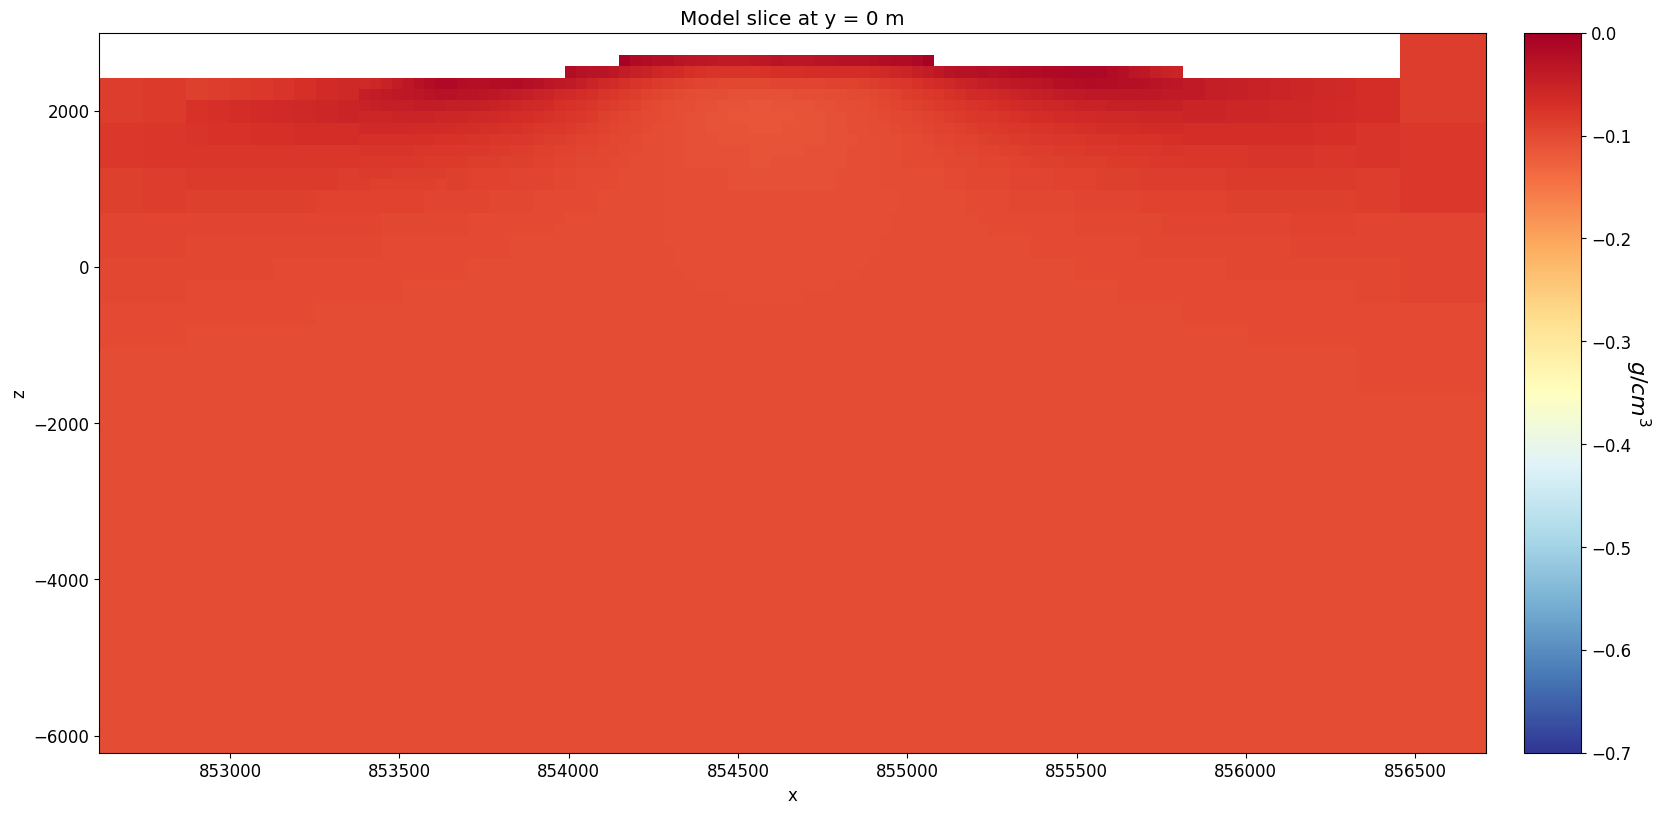

In [48]:
# Plot Recovered Model
fig = plt.figure(figsize=(19, 9))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

# norm = mpl.colors.Normalize(
#     vmin=np.min(-recovered_tensor_model), vmax=np.max(recovered_tensor_model)
# )

norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)

tree_mesh.plot_slice(
    tree_plotting_map * -recovered_tree_model,
    normal="Y",
    ax=ax1,
    ind=int(tree_mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# plt.savefig('65_1,1,1,1_0001.png', dpi=300)

plt.show()




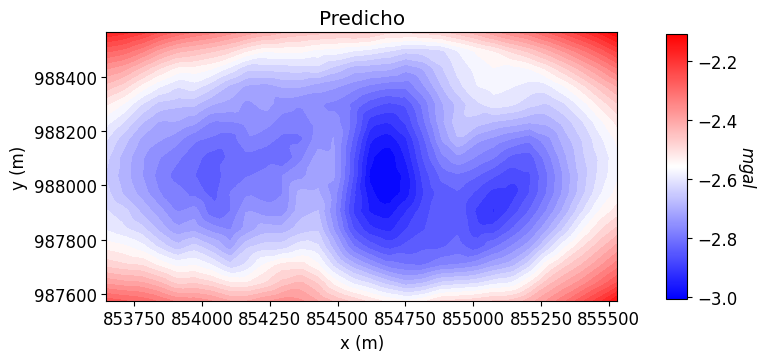

In [49]:
dpred_new = (inv_prob_irls.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred_new), np.max(dpred_new), np.min(-dpred_new), np.max(-dpred_new)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_new, 
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

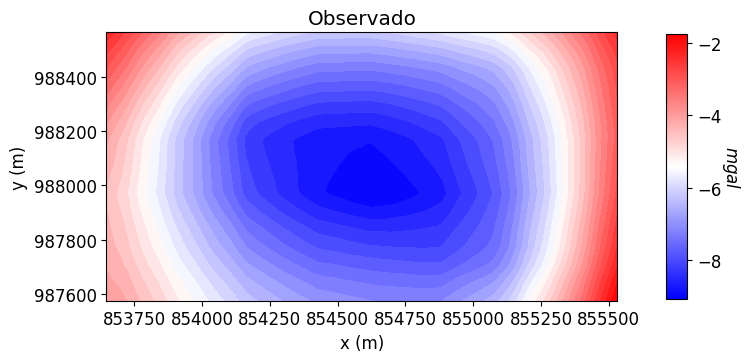

In [50]:
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

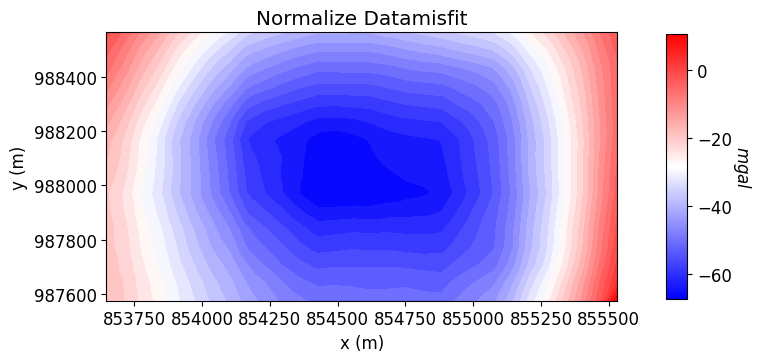

In [51]:
data_misfit_new= (dobs - dpred_new) / new_uncertainties

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit_new,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit_new), vmax=np.max(data_misfit_new))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [52]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration_new.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration_new.outDict[kk]['phi_d'])
        phi_m.append(save_iteration_new.outDict[kk]['phi_m'])
        beta.append(save_iteration_new.outDict[kk]['beta'])
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
    # Primera gráfica
    axs[0].plot(phi_m, phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)
    
    # Segunda gráfica
    line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
    point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    
    ax_1 = axs[1].twinx()
    line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
    point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    
    # Añadir leyendas
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    axs[1].legend(lines, labels, loc='upper left')
    
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    
    axs[0].legend()
    plt.tight_layout()    

interact(
    plot_tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), step=1),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, description='iteration', max=3, min=1), RadioButtons(description='sca…

<function __main__.plot_tikhonov_curve(iteration, scale)>

In [53]:
target_misfit.target

144.0

In [54]:
def plot_interactive_results(iteration):
    # Calcular data misfit normalizado
    dobs_iter = dobs
    
    # Obtener datos predichos de la iteración específica
    dpred_iter = save_iteration_new.outDict[iteration]['dpred']
    
    # Calcular data misfit normalizado
    data_misfit_iter = (dobs - dpred_new) / uncertainties
    
    # Configurar figura
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(19, 9))

    #Plotear el valor observado
    plot2Ddata(
        receiver_locations,
        dobs_iter,
        ax=ax0,
        ncontour=30,
        contourOpts={"cmap": "Spectral_r"}
    ) 
    ax0.set_title(f"Observado - Iteration {iteration}")
    ax0.set_xlabel("x (m)")
    ax0.set_ylabel("y (m)")  
    
    # Plotear datos predichos
    plot2Ddata(
        receiver_locations, 
        dpred_iter, 
        ax=ax1, 
        ncontour=30, 
        contourOpts={"cmap": "Spectral_r"}
    )
    ax1.set_title(f"Predicted Data - Iteration {iteration}")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("y (m)")
    
    # Plotear data misfit normalizado
    plot2Ddata(
        receiver_locations, 
        data_misfit_iter, 
        ax=ax2, 
        ncontour=30, 
        contourOpts={"cmap": "Spectral_r"}
    )
    ax2.set_title(f"Normalized Data Misfit - Iteration {iteration}")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("y (m)")
    
    plt.tight_layout()
    plt.show()

# Crear widget interactivo
interact(plot_interactive_results, 
         iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), step=1)
)

interactive(children=(IntSlider(value=1, description='iteration', max=3, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_interactive_results(iteration)>

In [56]:
def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
    # Recuperar el modelo (asegurándonos de que es el correcto)
    model = save_iteration_new.outDict[iteration]['m']
    
    # Si el modelo tiene más celdas de las que tiene la malla, recortarlo
    if model.size > mesh.nC:
        model = model[:mesh.nC]  # Recortar el modelo a las celdas de la malla

    # Si el modelo tiene menos celdas que la malla, expandirlo (debe alinearse con las celdas activas de la malla)
    if model.size < mesh.nC:
        expanded_model = np.zeros(mesh.nC)  # Crear un modelo vacío para todas las celdas
        expanded_model[:model.size] = model  # Asignar valores a las celdas disponibles
        model = expanded_model  # Usar el modelo expandido

    # Crear la figura para visualizar
    fig = plt.figure(figsize=(10, 10))

    # Graficar usando el modelo ajustado
    mesh.plot_3d_slicer(
        model,  # Usar el modelo ajustado
        clim=(0, vmax),
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap': 'Spectral_r'}
    )
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []  # Esto es necesario para matplotlib
    cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Density (g/cm³)', rotation=270, labelpad=20)

        # Configurar el título
    plt.suptitle(f'Recovered Model - Iteration {iteration}', fontsize=16)
    plt.show()
    
    # # Configurar etiquetas
    # plt.title(f'Recovered Model - Iteration {iteration}')
    # plt.colorbar(label='Density (g/cm³)')

# Configurar widgets interactivos
interact(
    plot_recovered_model, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), value=0),
    xslice=widgets.FloatText(value=854000, step=200),
    yslice=widgets.FloatText(value=988000, step=200), 
    zslice=widgets.FloatText(value=-2000, step=200),
    vmax=widgets.FloatText(value=0.7)
)


interactive(children=(IntSlider(value=1, description='iteration', max=7, min=1), FloatText(value=854000.0, des…

<function __main__.plot_recovered_model(iteration, xslice, yslice, zslice, vmax)>

In [299]:
def plot_3d_with_pyvista(model, notebook=True, threshold=0.0):
    pv.set_plot_theme("document")
    
    # Verificar y ajustar el tamaño del modelo
    if isinstance(model, np.ndarray):
        # Si el modelo es un array de NumPy, asegurarse de que tenga el tamaño correcto
        if model.size > mesh.nC:
            # Si el modelo es más grande, truncarlo
            model = model[:mesh.nC]
        elif model.size < mesh.nC:
            # Si el modelo es más pequeño, expandirlo con ceros
            expanded_model = np.zeros(mesh.nC)
            expanded_model[:model.size] = model
            model = expanded_model
    
    # Convertir la malla a un dataset de PyVista
    dataset = mesh.to_vtk({'Densidad': model})
    
    # Debugging: print dataset information
    print("Dataset points:", dataset.n_points)
    print("Dataset cells:", dataset.n_cells)
    
    # Debugging: print threshold information
    print("Threshold value:", threshold)
    print("Model min:", model.min())
    print("Model max:", model.max())
    
    # Crear la escena de renderizado
    p = pv.Plotter(notebook=notebook)
    p.hide_axes()  # Ocultar los ejes para una visualización más limpia
    
    # Filtrar por un umbral
    threshed = dataset.threshold(threshold, invert=False)
    
    # Debugging: print thresholded dataset information
    print("Thresholded points:", threshed.n_points)
    print("Thresholded cells:", threshed.n_cells)
    
    # Calcular los límites de los colores con base en los valores del modelo
    clim = [model.min(), model.max()]
    
    # Definir argumentos de la barra de colores
    scalar_bar_args = {
        'title': 'mGal',  # Título de la barra de colores
        'vertical': False
    }
    
    # Agregar los datos volumétricos a la escena
    dparams = dict(
        show_edges=False,
        cmap="Spectral",
        clim=clim,
        scalar_bar_args=scalar_bar_args,  # Argumentos de la barra de colores
    )
    
    # Debugging: try different thresholding approaches
    try:
        p.add_mesh(threshed, **dparams)
    except ValueError:
        # If thresholded mesh is empty, try plotting the original dataset
        print("Thresholded mesh is empty. Attempting to plot original dataset.")
        p.add_mesh(dataset, **dparams)
    
    # Ajustar la escala y la posición de la cámara
    p.set_scale(1, 1, 0.1)
    
    # Mostrar la escena
    p.show(window_size=[1024, 768])

# Llamar a la función con el modelo expandido
plot_3d_with_pyvista(recovered_tree_model, notebook=False, threshold=-0.504)

Dataset points: 45496
Dataset cells: 41538
Threshold value: -0.504
Model min: -1.0
Model max: 1.0
Thresholded points: 45492
Thresholded cells: 41530


In [300]:
def plot_3d_with_pyvista(model, notebook=True, threshold=0.0):
    pv.set_plot_theme("document")
    
    # Normalizar el modelo
    model_normalized = (model - model.min()) / (model.max() - model.min())
    model_normalized = model_normalized * -7
    
    # Verificar y ajustar el tamaño del modelo normalizado
    if isinstance(model_normalized, np.ndarray):
        # Si el modelo es un array de NumPy, asegurarse de que tenga el tamaño correcto
        if model_normalized.size > mesh.nC:
            # Si el modelo es más grande, truncarlo
            model_normalized = model_normalized[:mesh.nC]
        elif model_normalized.size < mesh.nC:
            # Si el modelo es más pequeño, expandirlo con ceros
            expanded_model = np.zeros(mesh.nC)
            expanded_model[:model_normalized.size] = model_normalized
            model_normalized = expanded_model
    
    # Convertir la malla a un dataset de PyVista
    dataset = mesh.to_vtk({'Densidad': model_normalized})
    
    # Debugging: print dataset information
    print("Dataset points:", dataset.n_points)
    print("Dataset cells:", dataset.n_cells)
    
    # Debugging: print threshold information
    print("Threshold value:", threshold)
    print("Model min:", model_normalized.min())
    print("Model max:", model_normalized.max())
    
    # Crear la escena de renderizado
    p = pv.Plotter(notebook=notebook)
    p.hide_axes()  # Ocultar los ejes para una visualización más limpia
    
    # Filtrar por un umbral
    threshed = dataset.threshold(threshold, invert=False)
    
    # Debugging: print thresholded dataset information
    print("Thresholded points:", threshed.n_points)
    print("Thresholded cells:", threshed.n_cells)
    
    # Calcular los límites de los colores con base en los valores del modelo
    clim = [model_normalized.min(), model_normalized.max()]
    
    # Definir argumentos de la barra de colores
    scalar_bar_args = {
        'title': 'mGal',  # Título de la barra de colores
        'vertical': False
    }
    
    # Agregar los datos volumétricos a la escena
    dparams = dict(
        show_edges=False,
        cmap="Spectral",
        clim=clim,
        scalar_bar_args=scalar_bar_args,  # Argumentos de la barra de colores
    )
    
    # Debugging: try different thresholding approaches
    try:
        p.add_mesh(threshed, **dparams)
    except ValueError:
        # If thresholded mesh is empty, try plotting the original dataset
        print("Thresholded mesh is empty. Attempting to plot original dataset.")
        p.add_mesh(dataset, **dparams)
    
    # Ajustar la escala y la posición de la cámara
    p.set_scale(1, 1, 0.1)
    
    # Mostrar la escena
    p.show(window_size=[1024, 768])

# Llamar a la función con el modelo expandido
plot_3d_with_pyvista(recovered_tree_model, notebook=False, threshold=4.5)

Dataset points: 45496
Dataset cells: 41538
Threshold value: 4.5
Model min: -7.0
Model max: 0.0
Thresholded points: 0
Thresholded cells: 0
Thresholded mesh is empty. Attempting to plot original dataset.


In [301]:
def plot_3d_with_pyvista(model, notebook=True, threshold=-0.7):
    pv.set_plot_theme("document")
    
    # Normalizar el modelo
    model_normalized = (model - model.min()) / (model.max() - model.min())
    model_normalized = model_normalized * -0.7
    
    # Verificar y ajustar el tamaño del modelo normalizado
    if isinstance(model_normalized, np.ndarray):
        # Si el modelo es un array de NumPy, asegurarse de que tenga el tamaño correcto
        if model_normalized.size > mesh.nC:
            # Si el modelo es más grande, truncarlo
            model_normalized = model_normalized[:mesh.nC]
        elif model_normalized.size < mesh.nC:
            # Si el modelo es más pequeño, expandirlo con ceros
            expanded_model = np.zeros(mesh.nC)
            expanded_model[:model_normalized.size] = model_normalized
            model_normalized = expanded_model
    
    # Convertir la malla a un dataset de PyVista
    dataset = mesh.to_vtk({'Densidad': model_normalized})
    
    # Debugging: print dataset information
    print("Dataset points:", dataset.n_points)
    print("Dataset cells:", dataset.n_cells)
    
    # Debugging: print threshold information
    print("Threshold value:", threshold)
    print("Model min:", model_normalized.min())
    print("Model max:", model_normalized.max())
    
    # Crear la escena de renderizado
    p = pv.Plotter(notebook=notebook)
    p.show_axes()  # Ocultar los ejes para una visualización más limpia
    
    # Filtrar por un umbral
    threshed = dataset.threshold(threshold, invert=True)
    
    # Debugging: print thresholded dataset information
    print("Thresholded points:", threshed.n_points)
    print("Thresholded cells:", threshed.n_cells)
    
    # Calcular los límites de los colores con base en los valores del modelo
    clim = [model_normalized.min(), model_normalized.max()]
    
    # Definir argumentos de la barra de colores
    scalar_bar_args = {
        'title': 'g/cc',  # Título de la barra de colores
        'vertical': False
    }
    
    # Agregar los datos volumétricos a la escena
    dparams = dict(
        show_edges=True,
        cmap="Spectral",
        clim=clim,
        scalar_bar_args=scalar_bar_args,  # Argumentos de la barra de colores
    )
    
    # Debugging: try different thresholding approaches
    try:
        p.add_mesh(threshed, **dparams)
    except ValueError:
        # If thresholded mesh is empty, try plotting the original dataset
        print("Thresholded mesh is empty. Attempting to plot original dataset.")
        p.add_mesh(dataset, **dparams)
    
    # Ajustar la escala y la posición de la cámara
    p.set_scale(1, 1, 1)
    
    # Mostrar la escena
    p.show(window_size=[1024, 768])

# Llamar a la función con el modelo expandido
plot_3d_with_pyvista(recovered_tree_model, notebook=False, threshold=-0.59)



Dataset points: 45496
Dataset cells: 41538
Threshold value: -0.59
Model min: -0.7
Model max: 0.0
Thresholded points: 5064
Thresholded cells: 3378


In [302]:
models = {'Densidad':tensor_plotting_map*recovered_tree_model}
databse = mesh.to_vtk(models)

In [303]:
databse.save('modelo_t_tree.vtk')

In [287]:
simulation_irls = gravity.simulation.Simulation3DIntegral(
    survey=survey, 
    mesh=mesh, 
    # rho=None,    
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="choclo",
    )

In [288]:
from simpeg import data_misfit

dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)

In [289]:
reg_irls = regularization.Sparse(
    mesh,
    active_cells=active_tensor_cells,
    alpha_s=dy**-1,
    alpha_x=1,
    alpha_y=1,
    alpha_z=10,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=True,
    norms=[0, 2, 2, 2],
)

In [290]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=90, lower=-1.0, upper=1.0, maxIterLS=30, maxIterCG=20, tolCG=1e-4
)

In [291]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [292]:
from simpeg import directives

save_iteration_new_new = directives.SaveOutputDictEveryIteration()
save_iteration_new_new.outDict = {}

sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True,)
                                                               # threshold_value=1e-10,
                                                               # threshold_method='amplitude',
                                                               # normalization_method='maximum',)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=20)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

update_irls = directives.Update_IRLS(
    coolingFactor=5.0,
    coolingRate=1,
    chifact_start=1.0,
    f_min_change=1e-3,
    max_irls_iterations=50,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
    save_iteration_new
]

In [293]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tensor_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.81e+00  4.67e+06  1.89e+05  5.01e+06    2.13e+02      0              
   1  3.62e-01  5.57e+05  3.39e+05  6.80e+05    1.57e+02      0              
   2  7.25e-02  8.30e+04  8.60e+05  1.45e+05    1.39e+02      0   Skip BFGS  
   3  1.45e-02  1.34e+04  1.23e+06  3.12e+04    1.35e+02      0   Skip BFGS  
   4  2.90e-03  3.26e+03  1.51e+06  7.62e+03    9.95e+01      0   Skip BFGS  
   5  5.80e-04  9.76e+02  1.84e+06  2.04e+03    5.89e+01      0   Skip BFGS  
Reached starting chifa

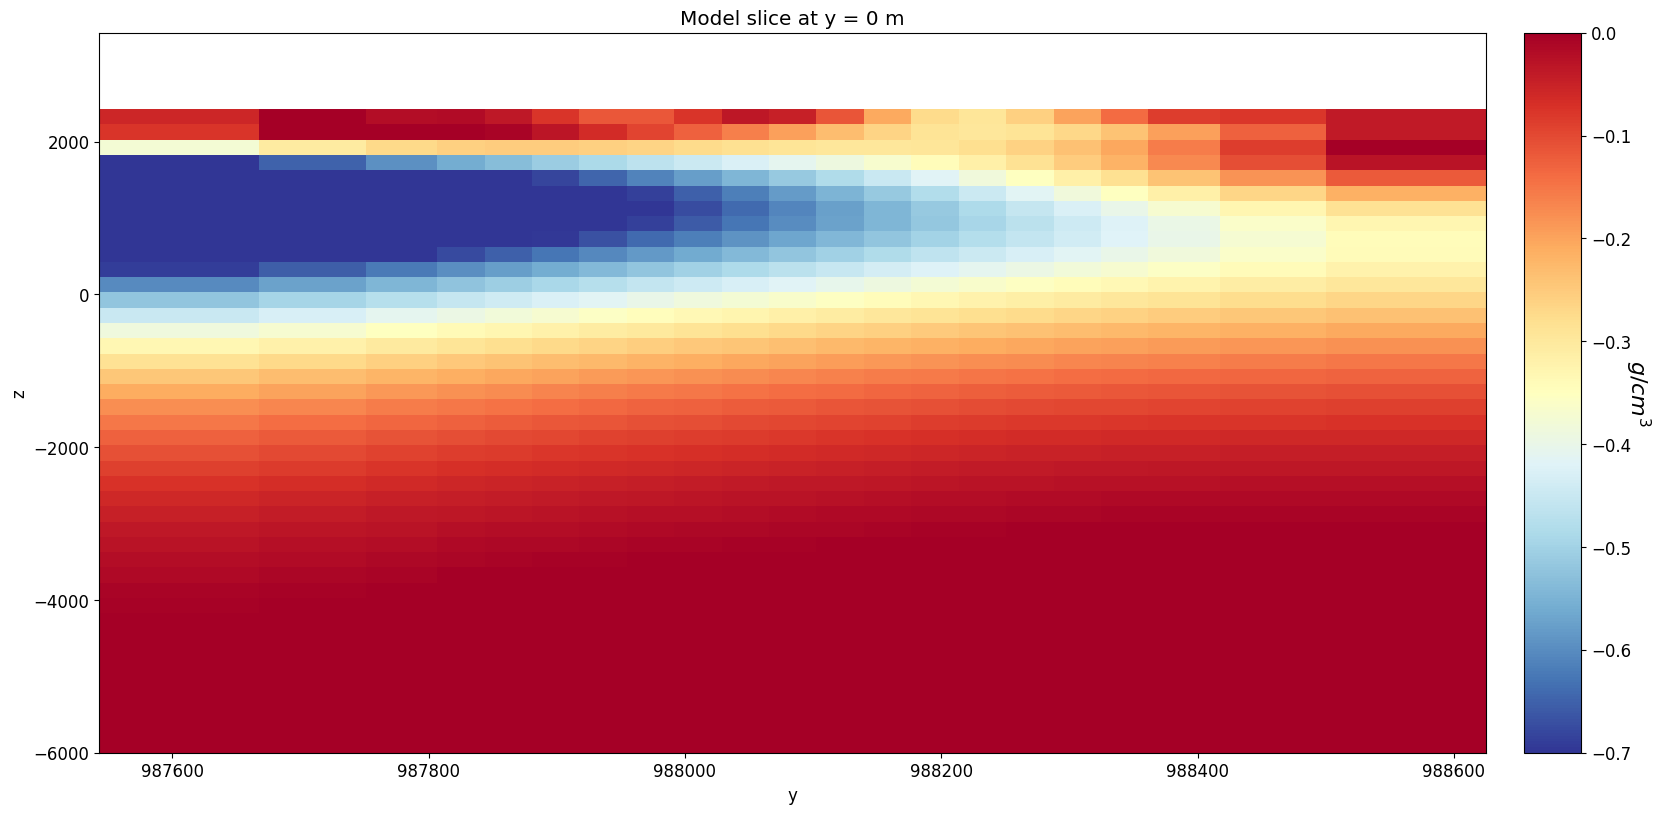

In [294]:
# Plot Recovered Model
fig = plt.figure(figsize=(19, 9))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

# norm = mpl.colors.Normalize(
#     vmin=np.min(-recovered_tensor_model), vmax=np.max(recovered_tensor_model)
# )

norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)

mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="X",
    ax=ax1,
    ind=int(mesh.shape_cells[2] / 7),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.savefig('65_1,1,1,1_0001.png', dpi=300)

plt.show()

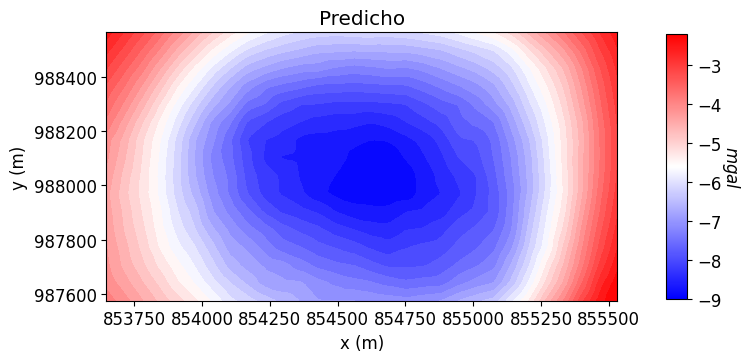

In [295]:
dpred_new_new = (inv_prob_irls.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred_new_new), np.max(dpred_new_new), np.min(-dpred_new_new), np.max(-dpred_new_new)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_new_new, 
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

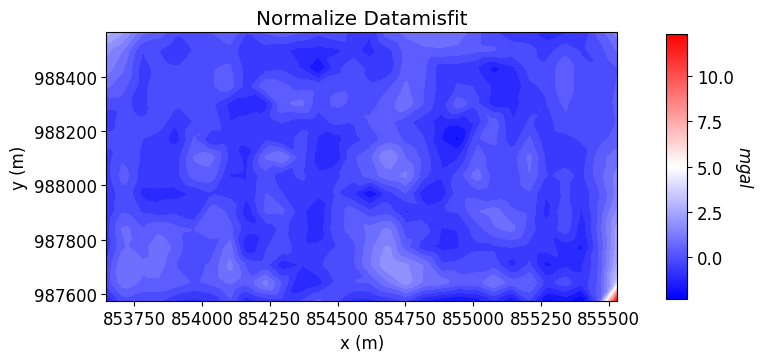

In [296]:
data_misfit_new= (dobs - dpred_new_new) / new_uncertainties

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit_new,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit_new), vmax=np.max(data_misfit_new))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [297]:
def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
    # Recuperar el modelo
    model = save_iteration.outDict[iteration]['m']

    # Expandir el modelo si el tamaño no coincide con el total de celdas
    if model.size != mesh.nC:
        expanded_model = np.zeros(mesh.nC)  # Crear un modelo vacío para todas las celdas
        expanded_model[:model.size] = model  # Asignar valores a las celdas disponibles
    else:
        expanded_model = model  # Usar el modelo directamente

    
    # Crear la figura
    fig = plt.figure(figsize=(12, 8))

    # Calcular los límites de los colores con base en los valores del modelo
    clim = [expanded_model.min(), expanded_model.max()]
    
    # Usar plot_3d_slicer y obtener los cortes en los tres planos
    mesh.plot_3d_slicer(
        expanded_model,
        clim=clim,
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap': 'Spectral_r'}
    )
    
    # Configurar barra de colores manualmente
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []  # Esto es necesario para matplotlib
    cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Density (g/cm³)', rotation=270, labelpad=20)

    # Configurar el título
    plt.suptitle(f'Recovered Model - Iteration {iteration}', fontsize=16)
    plt.show()

# Configurar widgets interactivos
interact(
    plot_recovered_model, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), value=0),
    xslice=widgets.FloatText(value=854500, step=1),
    yslice=widgets.FloatText(value=988000, step=1), 
    zslice=widgets.FloatText(value=2000, step=1),
    vmax=widgets.FloatText(value=0.7)
)


interactive(children=(IntSlider(value=1, description='iteration', max=7, min=1), FloatText(value=854500.0, des…

<function __main__.plot_recovered_model(iteration, xslice, yslice, zslice, vmax)>

In [298]:
def plot_3d_with_pyvista(model, notebook=True, threshold=0.0):
    pv.set_plot_theme("document")
    
    # Verificar y ajustar el tamaño del modelo
    if isinstance(model, np.ndarray):
        # Si el modelo es un array de NumPy, asegurarse de que tenga el tamaño correcto
        if model.size > mesh.nC:
            # Si el modelo es más grande, truncarlo
            model = model[:mesh.nC]
        elif model.size < mesh.nC:
            # Si el modelo es más pequeño, expandirlo con ceros
            expanded_model = np.zeros(mesh.nC)
            expanded_model[:model.size] = model
            model = expanded_model
    
    # Convertir la malla a un dataset de PyVista
    dataset = mesh.to_vtk({'Densidad': model})
    
    # Debugging: print dataset information
    print("Dataset points:", dataset.n_points)
    print("Dataset cells:", dataset.n_cells)
    
    # Debugging: print threshold information
    print("Threshold value:", threshold)
    print("Model min:", model.min())
    print("Model max:", model.max())
    
    # Crear la escena de renderizado
    p = pv.Plotter(notebook=notebook)
    p.hide_axes()  # Ocultar los ejes para una visualización más limpia
    
    # Filtrar por un umbral
    threshed = dataset.threshold(threshold, invert=True)
    
    # Debugging: print thresholded dataset information
    print("Thresholded points:", threshed.n_points)
    print("Thresholded cells:", threshed.n_cells)
    
    # Calcular los límites de los colores con base en los valores del modelo
    clim = [model.min(), model.max()]
    
    # Definir argumentos de la barra de colores
    scalar_bar_args = {
        'title': 'mGal',  # Título de la barra de colores
        'vertical': False
    }
    
    # Agregar los datos volumétricos a la escena
    dparams = dict(
        show_edges=False,
        cmap="Spectral",
        clim=clim,
        scalar_bar_args=scalar_bar_args,  # Argumentos de la barra de colores
    )
    
    # Debugging: try different thresholding approaches
    try:
        p.add_mesh(threshed, **dparams)
    except ValueError:
        # If thresholded mesh is empty, try plotting the original dataset
        print("Thresholded mesh is empty. Attempting to plot original dataset.")
        p.add_mesh(dataset, **dparams)
    
    # Ajustar la escala y la posición de la cámara
    p.set_scale(1, 1, 0.1)
    
    # Mostrar la escena
    p.show(window_size=[1024, 768])

# Llamar a la función con el modelo expandido
plot_3d_with_pyvista(recovered_tensor_model, notebook=False, threshold=-0.20)

Dataset points: 45496
Dataset cells: 41538
Threshold value: -0.2
Model min: -1.4518039985254025
Model max: 1.1423405361353263
Thresholded points: 12284
Thresholded cells: 9831
